In [6]:
import sys, os, json, subprocess
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
import sit_helper
standard_import_tool_plugin_path=sit_helper.load_standard_import_tool_plugin()
import cbm3_python_helper
cbm3_python_helper.load_cbm3_python()
import cbm3_python.simulation.projectsimulator
from cbm3_python.cbm3data.accessdb import AccessDB

In [12]:
def configobj(**kwargs):
    '''helper function for building configs'''
    return kwargs

In [13]:
inventory = [
    configobj(classifier_set=["Stand 1","Nonforest","Luvisolic (E. Canada)"], area=10, age=0, unfcccLandClass=1),
    configobj(classifier_set=["Stand 2","Nonforest","Brunisolic"], area=10, age=0, unfcccLandClass=1),
    configobj(classifier_set=["Stand 3","Nonforest","Average"], area=10, age=0, unfcccLandClass=1)
]

disturbance_events = [
    configobj(classifier_set=["?","?","?"], disturbance_type="Afforestation", 
              time_step=1, target=30, target_type="Area", sort="SORT_BY_SW_AGE"),
    configobj(classifier_set=["?","?","?"], disturbance_type="Clear-cut with slash-burn",
              time_step=100, target=30, target_type="Area", sort="SORT_BY_SW_AGE"),
    configobj(classifier_set=["?","?","?"], disturbance_type="Wildfire", 
              time_step=150, target=30, target_type="Area", sort="SORT_BY_SW_AGE")
]

transition_rules = [
    configobj(classifier_set_source=["?","?","?"], classifier_set_target=["?","Red pine","Forest Only"],
              disturbance_type="Afforestation", percent=100),
    configobj(classifier_set_source=["?","?","?"], classifier_set_target=["?","Red pine","Forest Only"],
              disturbance_type="Clear-cut with slash-burn", percent=100),
    configobj(classifier_set_source=["?","?","?"], classifier_set_target=["?","Red pine","Forest Only"],
              disturbance_type="Wildfire", percent=100)
]
growth_curve_data = [0,0,0,27,84,155,217,271,317,353,382,406,426,426]
growth_curves = [
    configobj(classifier_set=["?","Nonforest","?"], #growth curve for the non-forest stands with 0 merch vol
              leading_species_classifier_value="Not stocked", values=[0.0]*len(growth_curve_data)),
    configobj(classifier_set=["Stand 1","Red pine","Forest Only"], 
              leading_species_classifier_value="Red pine", values=growth_curve_data),
    configobj(classifier_set=["Stand 2","Red pine","Forest Only"], 
              leading_species_classifier_value="Red pine", values=growth_curve_data),
    configobj(classifier_set=["Stand 3","Red pine","Forest Only"], 
              leading_species_classifier_value="Red pine", values=growth_curve_data),
]


In [14]:
project_path = r".\tutorial1\tutorial1.mdb"
results_db_path = r".\tutorial1\tutorial1_results.mdb"
config = {
    "output_path": project_path,
    "data": {
        "age_class": {"age_class_size":5, "num_age_classes":14},
        "classifiers": ["Stand ID", "Leading Species", "Land Cover"],
        "disturbance_events": disturbance_events,
        "transition_rules": transition_rules,
        "inventory": inventory,
        "yield": growth_curves
    },
    "mapping_config": {
        "initialize_mapping": True,
        "spatial_units": {
          "mapping_mode": "SingleDefaultSpatialUnit",
          "default_spuid": 42
        },
        "disturbance_types": None,
        "species": {
          "species_classifier": "Leading Species",
          "species_mapping": [
            {
              "user_species": "Nonforest",
              "default_species": "Not stocked"
            }
          ]
        },
        "nonforest": None
    }
}
    



In [15]:
config_save_path = "config.json"
with open(config_save_path, 'w') as configfile:
    configfile.write(json.dumps(config, indent=4))

subprocess.check_call([
        standard_import_tool_plugin_path,
        '-c', config_save_path])

0

In [16]:
print(project_path)

.\tutorial1\tutorial1.mdb


In [17]:
toolbox_path = r'C:\Program Files (x86)\Operational-Scale CBM-CFS3'
results_db_path = cbm3_python.simulation.projectsimulator.run(
    aidb_path=os.path.join(toolbox_path, "admin", "dbs", "ArchiveIndex_Beta_Install.mdb"), 
    project_path=os.path.abspath(project_path), 
    toolbox_installation_dir=toolbox_path,
    cbm_exe_path=os.path.join(toolbox_path, "admin", "executables"),
    results_database_path= results_db_path)

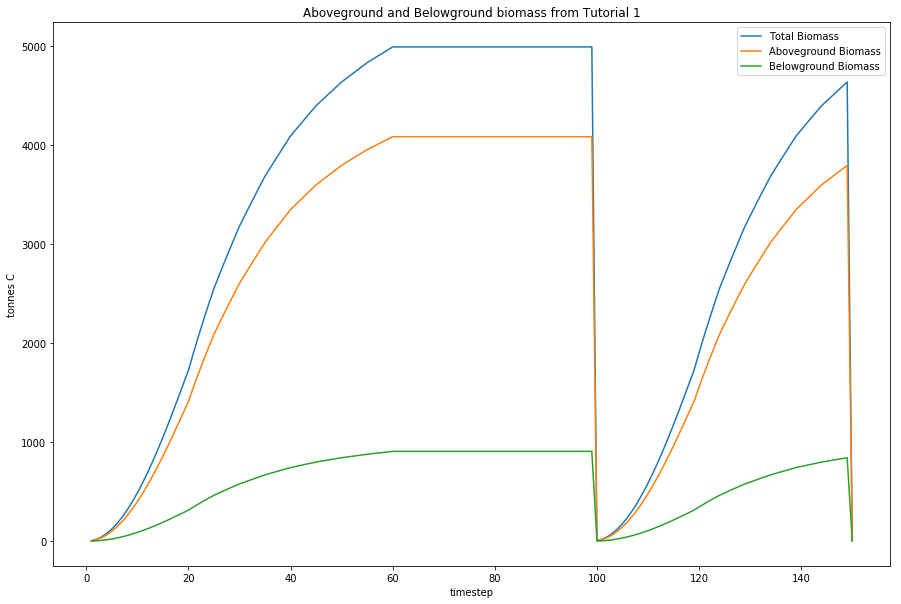

In [18]:
with AccessDB(results_db_path) as results_db:
    rows = results_db.Query("""
        select tpi.TimeStep,
        sum(tpi.SW_Merch + tpi.SW_Foliage + tpi.SW_Other +
            tpi.HW_Merch + tpi.HW_Foliage + tpi.HW_Other) as ag_bio,
        sum(tpi.SW_Coarse + tpi.SW_Fine + tpi.HW_Coarse + tpi.HW_Fine) as bg_bio
        from tblPoolIndicators tpi
        group by tpi.TimeStep
        order by tpi.TimeStep""")
    #create a n-timestep by 3 column array, columnss are timestep, ag-bio, bg-bio
    np_rows = np.array(list(rows))

    plt.figure(figsize=(15,10))
    
    plt.plot(np_rows[:,0],np_rows[:,1]+np_rows[:,2])
    plt.plot(np_rows[:,0],np_rows[:,1]) 
    plt.plot(np_rows[:,0],np_rows[:,2])
    
    plt.title("Aboveground and Belowground biomass from Tutorial 1")
    plt.ylabel("tonnes C")
    plt.xlabel("timestep")
    plt.legend(["Total Biomass", "Aboveground Biomass", "Belowground Biomass"], loc='upper right')
    plt.show()